## 导入python库

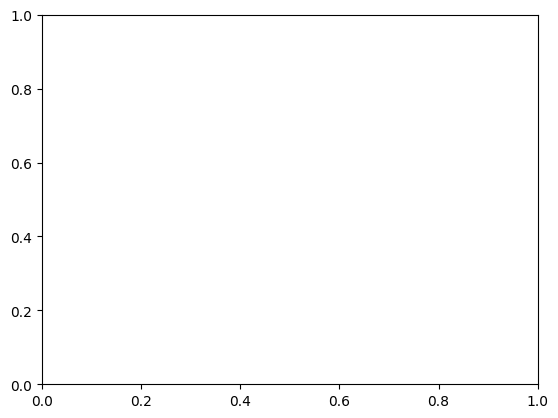

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('default')  # 设置画图的风格
import shap


from EIDG import EIDG
from vehicle_related import Vehicle
from vehicle_related import plot_vehicle
from vehicle_related import calculate_acceleration


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## IDM 模拟车辆跟车过程，并产生数据

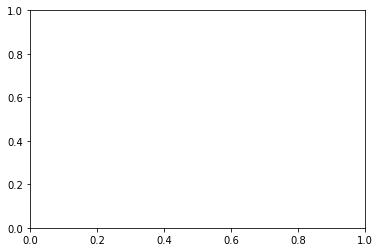

In [2]:

# 创建初始图
fig, ax = plt.subplots()
plt.ion()  # 打开交互模式
# 定义前视范围和后视范围
front_view = 80  # 前视范围，单位：米
rear_view = 80  # 后视范围，单位：米

# 循环调用fcn函数
def plot_vehicle(s1, s2):
    ax.clear()  # 清除前一次迭代的图
    # 计算x轴范围
    x_min = s1 - front_view
    x_max = s1 + rear_view

    # 绘制道路
    road_length = front_view + rear_view  # 道路长度，单位：米
    road_width = 3.5  # 道路宽度，单位：米
    ax.add_patch(plt.Rectangle((x_min, 0), road_length, road_width, edgecolor='k', facecolor='w'))

    # 定义车辆的绝对尺寸
    car_length = 4  # 车辆的长度，单位：米
    car_width = 2  # 车辆的宽度，单位：米

    # 绘制第一辆车
    car1_center = s1  # 第一辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car1_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='r', facecolor='none'))

    # 绘制第二辆车
    car2_center = s2  # 第二辆车的质心位置，单位：米
    ax.add_patch(plt.Rectangle((car2_center - car_length / 2, (road_width - car_width) / 2), car_length, car_width,
                               edgecolor='b', facecolor='none'))

    # 设置坐标轴
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([0, road_width])

    # 添加标签和标题
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Width (m)')
    ax.set_title('Road with Cars')

    plt.pause(0.2)  # 等待一段时间以便查看图像


# 创建两辆车
car1 = Vehicle(initial_speed=0, initial_position=0)
car2 = Vehicle(initial_speed=10, initial_position=30)

# 模拟时间步长和总模拟时间
time_step = 0.05  # 时间步长（秒）
total_simulation_time = 20  # 总模拟时间（秒）

# 列表用于存储车辆状态
s_list = []
v_list = []
delta_v_list = []
acc_list = []
for t in np.arange(0, total_simulation_time, time_step):
    # 计算两辆车的加速度
    if (car2.position - car1.position) < 4:
        print("crash")
        break

    # plot_vehicle(car1.position, car2.position)

    s = car2.position - car1.position
    v = car1.speed
    delta_v = car1.speed - car2.speed

    car1_acceleration = calculate_acceleration(s, v, delta_v)
    # 更新车辆状态
    car1.update(time_step, car1_acceleration)
    car2.update(time_step, 0)

    # 保存车辆速度和位置
    s_list.append(s)
    v_list.append(v)
    delta_v_list.append(delta_v)
    acc_list.append(car1_acceleration)

# 关闭交互模式
plt.ioff()
plt.show()

In [3]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# 假设您已经有了数据 v、s、delta_v 和 a_v
# 假设数据已经通过数据处理和特征工程
s = np.array(s_list)
v = np.array(v_list)
delta_v= np.array(delta_v_list)
# 数据预处理
X = np.column_stack((s, v, delta_v))
y = np.array(acc_list)

##  XGBoost模型训练

XGBoost R-squared (R2): 0.9938289671487315


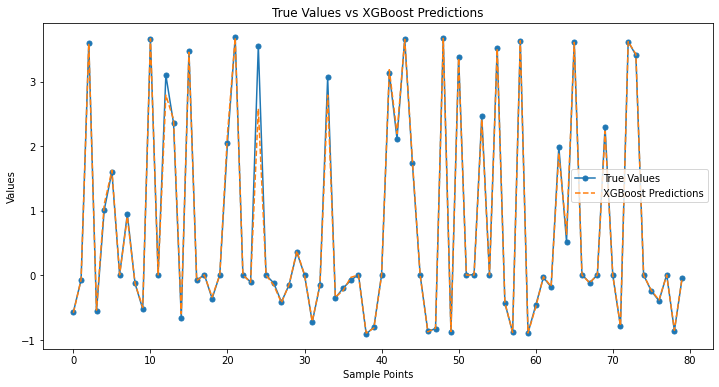

In [4]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用XGBoost进行回归
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
xgb_reg.fit(X_train, y_train)

# 计算XGBoost的预测输出
xgb_predictions = xgb_reg.predict(X_test)

# 计算R-squared（R2）来衡量模型准确性
xgb_r2 = r2_score(y_test, xgb_predictions)

print("XGBoost R-squared (R2):", xgb_r2)

# 绘制真实值和XGBoost预测值的曲线对比
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Values', marker='o', markersize=5)
plt.plot(range(len(y_test)), xgb_predictions, label='XGBoost Predictions', linestyle='--')
plt.xlabel('Sample Points')
plt.ylabel('Values')
plt.legend()
plt.title('True Values vs XGBoost Predictions')
plt.show()

### 不同归因方法计算时间对比（EIDG、KernelSHAP、LIME）

In [5]:
import time
import lime
from lime.lime_tabular import LimeTabularExplainer

# 实例化三种方法  EIDG、kernel_shap、 LIME
eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=50, h=0.1, m=10, pos=True)
explainer_xgb = shap.KernelExplainer(xgb_reg.predict, eidg_instance.x_baselines)
explainer_lime = LimeTabularExplainer(X_train, mode="regression")
# explainer_xgb_eidg_values = eidg_instance.integrated_gradients(X_train)
# aaaaa = eidg_instance.integrated_gradients(X_train)
element_counts = [10, 50, 100, 200, 300]
time_save_eidg = []
time_save_kernel_shap = []
time_save_lime = []
# # element_counts = [2] # Define different numbers of elements in x
# 
for element_count in element_counts:
    start_time = time.perf_counter()
    ig = eidg_instance.integrated_gradients(X_train[0:element_count])
    end_time = time.perf_counter()
    time_save_eidg.append(end_time - start_time)
    
    start_time = time.perf_counter()
    explainer_xgb_shap_values = explainer_xgb.shap_values(X_train[0:element_count])
    end_time = time.perf_counter()
    time_save_kernel_shap.append(end_time - start_time)
    
    # LIME方法只接受单个样本输入，所以其计算时间我们用单个样本计算时间*样本数量近似表示
    start_time_lime = time.perf_counter()
    lime_explanation = explainer_lime.explain_instance(X_train[0], xgb_reg.predict)
    end_time_lime = time.perf_counter()
    time_save_lime.append((end_time_lime - start_time_lime) * element_count)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import pandas as pd

# 创建列名
columns = ["样本数10", "样本数50", "样本数100", "样本数200", "样本数300"]
# 创建行名
index = ["EIDG", "kernelShap", "LIME"]

# 创建一个空的 DataFrame
df = pd.DataFrame(index=index, columns=columns)

# 填充 DataFrame
# 这里可以根据你的实际情况填充数据，我这里仅作示例
df.loc["EIDG"] = np.array(time_save_eidg)
df.loc["kernelShap"] = np.array(time_save_kernel_shap)
df.loc["LIME"] = np.array(time_save_lime)

In [ ]:
# 检查并创建 data_record 文件夹
import os
folder_path = "data_record"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 拼接 CSV 文件路径
csv_file_path = os.path.join(folder_path, "computation_comparison.csv")
df.to_csv(csv_file_path)

### 不同参数设置下EIDG计算时间对比

In [ ]:
# 实例化三种方法  EIDG、kernel_shap、 LIME
eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=50, h=0.1, m=10, pos=True)
explainer_xgb = shap.KernelExplainer(xgb_reg.predict, eidg_instance.x_baselines)
explainer_lime = LimeTabularExplainer(X_train, mode="regression")
# explainer_xgb_eidg_values = eidg_instance.integrated_gradients(X_train)
# aaaaa = eidg_instance.integrated_gradients(X_train)
steps_numbers = [10, 50, 100, 200, 300]
baselines_numbers = [10, 50, 100, 200, 300]


In [ ]:
time_record = np.zeros((len(steps_numbers),len(baselines_numbers)))
# # element_counts = [2] # Define different numbers of elements in x
# 
for i, baselines_number in enumerate(baselines_numbers):
    for j, steps_number in enumerate(steps_numbers):
        eidg_instance = EIDG(x_baselines=X_train, model = xgb_reg.predict,steps=steps_number, h=0.1, m=baselines_number, pos=True)
        start_time = time.perf_counter()
        ig = eidg_instance.integrated_gradients(X_train)
        end_time = time.perf_counter()
        time_record[i, j] = end_time - start_time

In [ ]:
# 创建列名
columns = ["步数10", "步数50", "步数100", "步数200", "步数300"]
# 创建行名
index = ["基值数10", "基值数50", "基值数100", "基值数200", "基值数300"]

# 创建一个空的 DataFrame
df1 = pd.DataFrame(index=index, columns=columns, data=time_record)

In [ ]:
# 检查并创建 data_record 文件夹
import os
folder_path = "data_record"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
# 拼接 CSV 文件路径
csv_file_path = os.path.join(folder_path, "computation_comparison_of_EIDG.csv")
df1.to_csv(csv_file_path)